In [0]:
pip install pydicom

     |████████████████████████████████| 7.0MB 3.2MB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
#os.chdir('/content/drive/My Drive/RSNA')

In [0]:
!ls

stage_2_detailed_class_info.csv  test		 train_extracted
stage_2_sample_submission.csv	 test_extracted
stage_2_train_labels.csv	 train


In [0]:
detail_class_path = '/content/drive/My Drive/RSNA/stage_2_detailed_class_info.csv'
bbox_path = '/content/drive/My Drive/RSNA/stage_2_train_labels.csv'
dicom_dir = '/content/drive/My Drive/RSNA/stage_2_train_images/'

In [0]:
detailed_class_df = pd.read_csv(detail_class_path)
print('No of samples in deatiled class:',detailed_class_df.shape[0])

bbox_df=pd.read_csv(bbox_path)
print('No of samples in bounding box dataframe:',bbox_df.shape[0])
#print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')

No of samples in deatiled class: 30227
No of samples in bounding box dataframe: 30227


In [0]:
detailed_class_df.sample(10)

,patientId,class
10220,6d662191-3763-416d-a8c4-f4e5c910199a,Normal
15454,9708b405-8887-4824-b354-f7c245eedfc3,Lung Opacity
17108,a4444af9-6137-4f0e-9b51-ca7236cf43b2,Lung Opacity
12548,7fa32698-17e4-4041-9f38-38fcf83c8eea,No Lung Opacity / Not Normal
13065,83ee7f2c-8974-4201-8fab-87cde6f89038,Normal
2417,31bfdeb1-9233-4db2-849f-bb890cd0d397,No Lung Opacity / Not Normal
665,09629e2b-7f1e-499c-aab7-2bff196f034b,Normal
4858,41e4abf6-897e-464d-9cec-ed3c51d8809e,Lung Opacity
18569,aed59257-3d45-4b91-bd48-9440ac7f843f,No Lung Opacity / Not Normal
29856,27b32500-40ef-4c14-ab88-ace5e9ceea27,Lung Opacity


In [0]:
bbox_df.sample(10)

,patientId,x,y,width,height,Target
27477,f3f98941-5ec0-450a-a616-16f23750184b,NaN,NaN,NaN,NaN,0
4756,412c7d55-6146-450c-a4bc-0c87cb332f00,NaN,NaN,NaN,NaN,0
14892,926af361-4652-4d71-9240-7a6f91393f48,NaN,NaN,NaN,NaN,0
22441,caef3a9d-6767-4cd3-8c18-ecdb3f07bb1e,NaN,NaN,NaN,NaN,0
5029,438090bc-eafe-448f-99de-33a5929cd44e,NaN,NaN,NaN,NaN,0
27485,f40ca2b6-61d7-4400-8768-ffe697b9b48f,NaN,NaN,NaN,NaN,0
23352,d2442b84-f67b-4d68-8eea-f03e38502330,NaN,NaN,NaN,NaN,0
13969,8b2bfb73-f775-4aea-99f4-ba8e930ab325,NaN,NaN,NaN,NaN,0
23497,d39ee987-53b2-4166-ab40-2f5e79f7ed54,NaN,NaN,NaN,NaN,0
15978,9b1df62b-c463-4379-99dd-6e0fa8b89db5,NaN,NaN,NaN,NaN,0


Lets check if any null values in both the dataframes

In [0]:
print(detailed_class_df.isna().sum())

patientId    0
class        0
dtype: int64


In [0]:
print(bbox_df.isna().sum())

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64


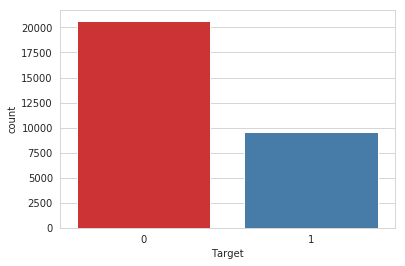

In [0]:
#Target data visualization
sns.countplot(bbox_df['Target'],order = bbox_df['Target'].value_counts().index, palette='Set1')

In [0]:
print("\nPercentage NA values in bbox dataframein x column:\n",bbox_df['x'].isna().sum()/bbox_df.shape[0]*100)
print("\nPercentage NA values in bbox dataframein y column:\n",bbox_df['y'].isna().sum()/bbox_df.shape[0]*100)
print("\nPercentage NA values in bbox dataframein width column:\n",bbox_df['width'].isna().sum()/bbox_df.shape[0]*100)
print("\nPercentage NA values in bbox dataframein height column:\n",bbox_df['height'].isna().sum()/bbox_df.shape[0]*100)
print("\nPrecent of samples having bbox values in given data is:",100-(bbox_df['x'].isna().sum()/bbox_df.shape[0]*100))
print("\nBounding box values present in {} of samples out of {} samples".format(bbox_df.shape[0]-bbox_df['x'].isna().sum(),bbox_df.shape[0]))


Percentage NA values in bbox dataframein x column:
 68.38918847388096

Percentage NA values in bbox dataframein y column:
 68.38918847388096

Percentage NA values in bbox dataframein width column:
 68.38918847388096

Percentage NA values in bbox dataframein height column:
 68.38918847388096

Precent of samples having bbox values in given data is: 31.610811526119036

Bounding box values present in 9555 of samples out of 30227 samples


Total 68.38% data in bounding box dataframe is NA,that means only 31.6% having the positive "Lung Opacity" problem.
Lets revalidate the same using the visualization

In [0]:
detailed_class_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [0]:
bbox_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

# #It is clear with the above cell output that Lung opacity is present for 9555 patients 

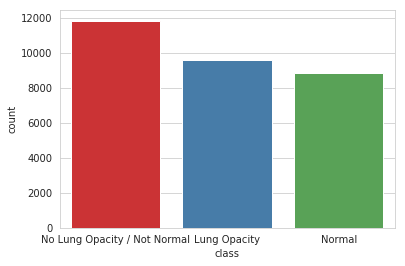

In [0]:
sns.countplot(detailed_class_df['class'],order = detailed_class_df['class'].value_counts().index, palette='Set1')

#Lets visualize how the x,y and width and height values spread for lung opacity positive patients

In [0]:
LungOpacity = bbox_df[bbox_df['Target']==1]
lung_opacity_positive_df=pd.DataFrame(LungOpacity,columns=bbox_df.columns)

In [0]:
lung_opacity_positive_df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')

In [0]:

lung_opacity_positive_df.drop(['patientId','Target'],inplace=True,axis=1)

In [0]:
lung_opacity_positive_df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0


In [0]:
lung_opacity_positive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 30226
Data columns (total 4 columns):
x         9555 non-null float64
y         9555 non-null float64
width     9555 non-null float64
height    9555 non-null float64
dtypes: float64(4)
memory usage: 373.2 KB


In [0]:
q1, q3= np.percentile(lung_opacity_positive_df,[25,75])
iqr = q3 - q1

lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

LungOpacity_df_without_outliers = lung_opacity_positive_df[(lung_opacity_positive_df > lower_bound) & (lung_opacity_positive_df < upper_bound )]
print("No of samples without outliers in bounding box dataframe for lung opacity positive patients is",LungOpacity_df_without_outliers.shape[0])

No of samples without outliers in bounding box dataframe for lung opacity positive patients is 9555


From above cell ouput it is evident that all the psotive samples from bounding box dataframe can be used as the no of samples with and without outliers are same (9555)

<Figure size 432x288 with 0 Axes>

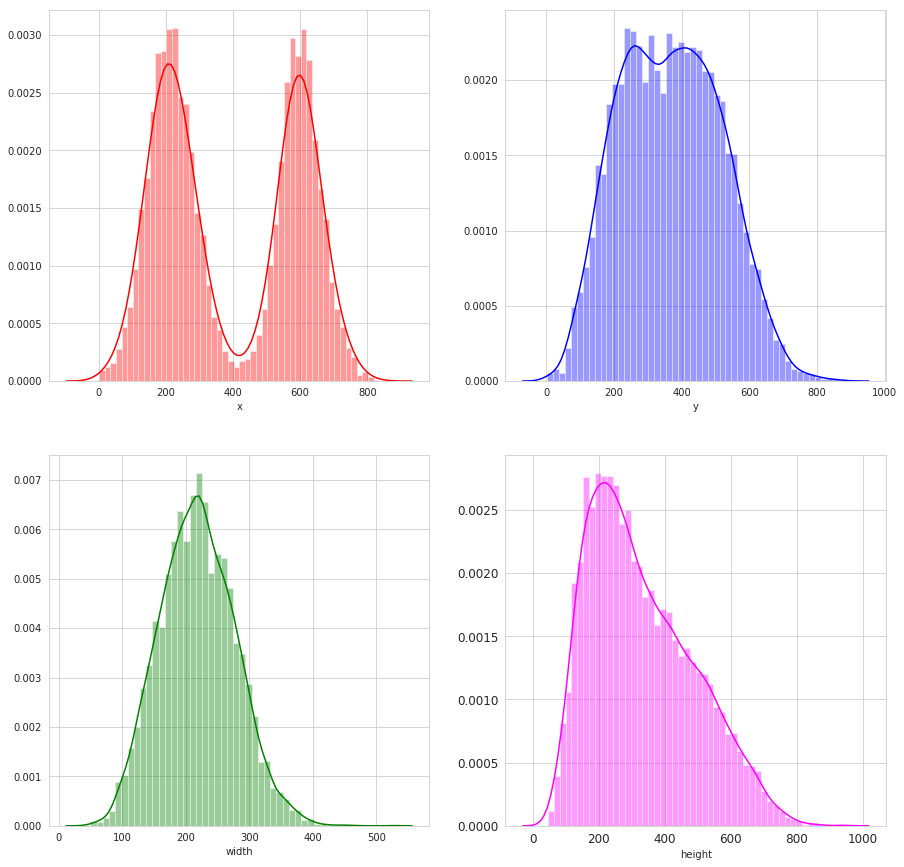

In [0]:
LungOpacity = bbox_df[bbox_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(15,15))
sns.distplot(LungOpacity['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(LungOpacity['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(LungOpacity['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(LungOpacity['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

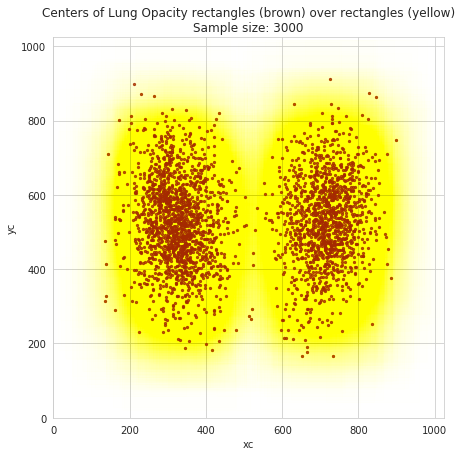

In [0]:
LungOpacity_sample = bbox_df[bbox_df['Target']==1].sample(3000)
fig, ax = plt.subplots(1,1,figsize=(7,7))

LungOpacity_sample['xc'] = LungOpacity_sample['x'] +LungOpacity_sample['width'] / 2
LungOpacity_sample['yc'] = LungOpacity_sample['y'] + LungOpacity_sample['height'] / 2

plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 3000")
LungOpacity_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")


for i, crt_sample in LungOpacity_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

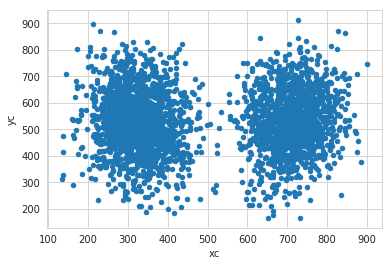

In [0]:

LungOpacity_sample.query('Target==1').plot.scatter(x='xc', y='yc')

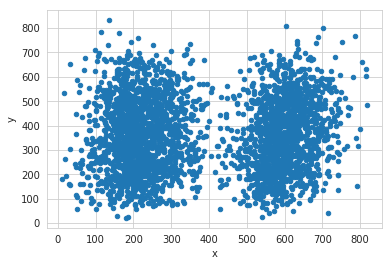

In [0]:

LungOpacity_sample.query('Target==1').plot.scatter(x='x', y='y')

From above visualizations we can observe that The middle area of the lungs are most impacted with the opacity problems,how ever the impact area is spread across the lungs

Lets find howmany unique patients are present in bounding box and detailed dataframes

In [0]:
print("\nNumber of unique patients in the bounding box dataframe are: {} out of total entries {}".format(bbox_df['patientId'].nunique(),bbox_df.shape[0]))
print("\nNumber of unique patients in the detailed class dataframe are:{} out of total entries {}:".format(detailed_class_df['patientId'].nunique(),detailed_class_df.shape[0]))




Number of unique patients in the bounding box dataframe are: 26684 out of total entries 30227

Number of unique patients in the detailed class dataframe are:26684 out of total entries 30227:


There are total 266684 unique patients are presnet out of 30227 entries,It could be possible that some patients might of got through mutiple tests.

In [0]:
duplicateRows_bbox = bbox_df[bbox_df.duplicated(['patientId'])]

duplicateRows_detailed= detailed_class_df[detailed_class_df.duplicated(['patientId'])]

print("Number of duplicate patient entries in bbox dataframe are:",duplicateRows_bbox.shape[0])


print("Number of duplicate patient entries in detailed dataframe are:",duplicateRows_detailed.shape[0])

print("duplicated patient id's in bbox are:/n",duplicateRows_bbox)

print("duplicated patient id's in bbox are:/n",duplicateRows_detailed)

Number of duplicate patient entries in bbox dataframe are: 3543
Number of duplicate patient entries in detailed dataframe are: 3543
duplicated patient id's in bbox are:/n                                   patientId      x  ...  height  Target
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  ...   453.0       1
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  ...   137.0       1
15     00aecb01-a116-45a2-956c-08d2fa55433f  547.0  ...   165.0       1
17     00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  ...   284.0       1
20     00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  ...   476.0       1
25     010ccb9f-6d46-4380-af11-84f87397a1b8  301.0  ...   279.0       1
28     012a5620-d082-4bb8-9b3b-e72d8938000c  678.0  ...   340.0       1
33     0174c4bb-28f5-41e3-a13f-a396badc18bd  599.0  ...   508.0       1
37     019d950b-dd38-4cf3-a686-527a75728be6  604.0  ...   328.0       1
42     01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce  609.0  ...   355.0       1
44     01a7353d-25bb-4ff8-916b-f50dd5

In [0]:
duplicateRows_bbox['Target'].value_counts()

1    3543
Name: Target, dtype: int64

#The interesting inference from above analysis is all the duplicate entries of patients ,who have gone through mutiple tests are when they are found positive for lung opacities,that means out of total 9555 entries ,3543 entries are duplicated.We can say that 6012 patients who are found to be positive for lung opacity condition have gon thorugh single test and found positive and remaining 3543 are gone more than one test to confirm the lung opacity.

In [0]:
comb_bbox_df = pd.concat([bbox_df,detailed_class_df.drop('patientId',axis=1)],axis=1)
print('No of patients in combined Dataframe shape after merging the detailed and bounding box dataframes are:',comb_bbox_df.shape[0])

No of patients in combined Dataframe shape after merging the detailed and bounding box dataframes are: 30227


In [0]:
comb_bbox_df.shape

(30227, 7)

In [0]:
comb_bbox_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [0]:
#Lets read the dicom images provided and perform some EDA

In [0]:
cd /content/drive/My Drive/RSNA/

/content/drive/My Drive/RSNA


In [0]:
ls

Chexnet/                         test_extracted/
first_try.h5                     train/
inception_all_sgd.h5             train_1/
resnet50_all_sgd.h5              train_extracted/
stage_2_detailed_class_info.csv  transfer_2000_all_sgd.h5
stage_2_sample_submission.csv    transfer_all_sgd.h5
stage_2_train_labels.csv         valid_1/
test/                            vgg19_all_sgd.h5


In [0]:
image_train_path = os.listdir('/content/drive/My Drive/RSNA/train_extracted/')
image_test_path = os.listdir('/content/drive/My Drive/RSNA/test_extracted/')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


Lets read the First dicom file and check the format of the file and important attributes

In [0]:
patientId = comb_bbox_df['patientId'][0]
dcm_file = '/content/drive/My Drive/RSNA/train_extracted/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

#For lung opacity patients lets check the distribution of Age,Gender,Modality and the view which detected the symptoms

In [0]:
lungOpacity_positive=bbox_df[bbox_df['Target']==1]
lungOpacity_normal=bbox_df[bbox_df['Target']==0]

In [0]:
lungOpacity_normal.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [0]:
lungOpacity_positive.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [0]:
patientAge=[]
patientGender=[]
patientModality=[]
patientView=[]

for pid in lungOpacity_positive['patientId']:
  
    file_path = os.path.join('/content/drive/My Drive/RSNA/train_extracted/', pid+".dcm")
    dataset = pydicom.dcmread(file_path)
    patientAge.append(dataset.PatientAge)
    patientGender.append(dataset.PatientSex)
    patientModality.append(dataset.Modality)
    patientView.append(dataset.ViewPosition)

In [0]:
dicom_df = pd.DataFrame({'Age':patientAge})
dicom_df['Gender']=patientGender
dicom_df['View']=patientView
dicom_df['Modality']=patientModality

In [0]:
dicom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9555 entries, 0 to 9554
Data columns (total 4 columns):
Age         9555 non-null object
Gender      9555 non-null object
View        9555 non-null object
Modality    9555 non-null object
dtypes: object(4)
memory usage: 298.7+ KB


In [0]:
dicom_df['Age']=dicom_df['Age'].astype('float')
dicom_df['View']=dicom_df['View'].astype('category')
dicom_df['Gender']=dicom_df['Gender'].astype('category')

In [0]:
dicom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9555 entries, 0 to 9554
Data columns (total 4 columns):
Age         9555 non-null float64
Gender      9555 non-null category
View        9555 non-null category
Modality    9555 non-null object
dtypes: category(2), float64(1), object(1)
memory usage: 168.2+ KB


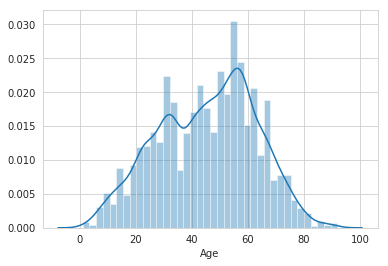

In [0]:
sns.distplot(dicom_df['Age'],kde=True)

From the above distribution it is evident that all the age groups are effected by Lung opacity ,majority of the patients are between 50 and 60 years age band.



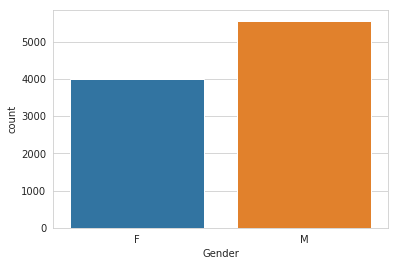

In [0]:
sns.countplot(dicom_df['Gender'])


#It is evident that males are more effected than females with LungOpacity problem

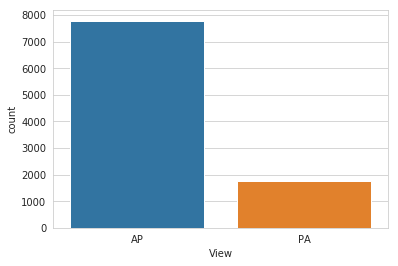

In [0]:
sns.countplot(dicom_df['View'])

Majority of the finding for Lung opacity are done in AP view,only 10% are found in PA view.

In [0]:
#The following code is taken from https://www.kaggle.com/peterchang77/exploratory-data-analysis

import glob, pandas as pd
import matplotlib.pyplot as plt
import pydicom, numpy as np

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/content/drive/My Drive/RSNA/train_extracted/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

df = pd.read_csv('/content/drive/My Drive/RSNA/stage_2_train_labels.csv')

patient_class = pd.read_csv('/content/drive/My Drive/RSNA/stage_2_detailed_class_info.csv', index_col=0)

parsed = parse_data(df)

patientId = df['patientId'][0]
print('Just a checking that everything is working fine...')
print(parsed[patientId])
print(patient_class.loc[patientId])

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

Just a checking that everything is working fine...
{'dicom': '/content/drive/My Drive/RSNA/train_extracted/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
class    No Lung Opacity / Not Normal
Name: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, dtype: object


In [0]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


class    No Lung Opacity / Not Normal
Name: 00322d4d-1c29-4943-afc9-b6754be640eb, dtype: object


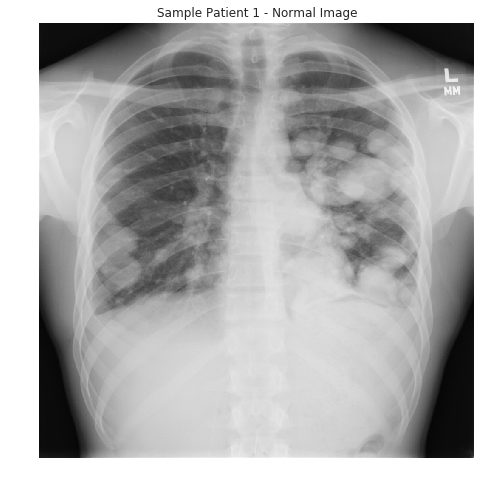

In [0]:
patientId = df['patientId'][2]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 1 - Normal Image")

draw(parsed[patientId])

                                             class
patientId                                         
00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity


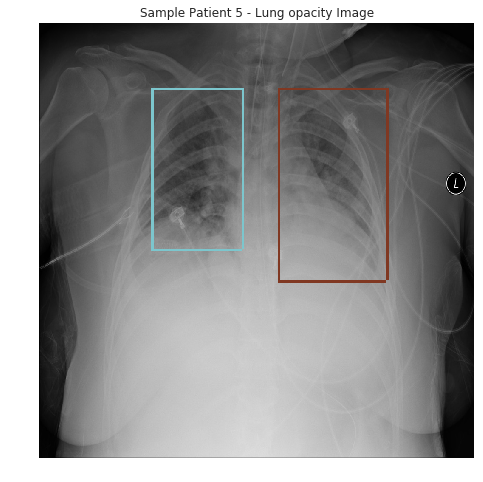

In [0]:
#Lets see how the patient X ray shows when they are positive for Lung Opacity
patientId = df['patientId'][4]
print(patient_class.loc[patientId])

plt.figure(figsize=(10,8))
plt.title("Sample Patient 5 - Lung opacity Image")

draw(parsed[patientId])